# CSE-144-01 - 2025 Winter - HW 3

## Instruction

- Submit your assignments onto **Canvas** by the due date. Upload a singel `.ipynb` file with all the necessary output.
- Don't change the input and output structure of pre-defined functions. Only write your code between `YOUR CODE STARTS HERE` and `YOUR CODE ENDS HERE`. You won't get the points if you alter the code outside these two dividing lines. Most coding parts can be finished with about 5-6 lines of codes.
- Make sure you have installed required packages imported in the first code block.

## Rubric

The assignment is worth 40pts in total:
- Data Augmentation and Normalization (3pts)
    - Augmentation (2pts)
    - Normalization (1pt)
- Model (9pts)
    - Initialize weights and biases (2pts)
    - ReLU (1pt)
    - Softmax (2pt)
    - Forward (4pt)
- Optimization Targets (11pts)
    - Cross-Entrophy Loss (2pts)
    - Back-Propagation for Cross-Entrophy Loss (5pts)
    - L2 Regularization (2pts)
    - Back-Propagation for L2 Regularization (2pts)
- SGD Optimizer (1pt)
- Trainer (11pt)
    - `train` (8pts)
        - Shuffle the training set before each epoch (2pts)
        - Get the batch data (1pt)
        - Apply augmentation and normalization (1pt)
        - Add l2 regularization to the loss (1pt)
        - Compute gradient from Cross-Entrophy Loss (1pt)
        - Add L2 gradients if regularization is applied (1pt)
        - Update parameters using the optimizer (1pt)
    - `evaluate` (3pts)
        - Only do normalization when testing on validation or test set (1pt)
        - Compute Cross-Entrophy Loss and L2 Regularization if needed (1pt)
        - Compute accuracy (1pt)
- Training (6pts)
    - Model Definition (1pt)
    - Hyper-Parameters Tuning (5pts)
- Training with SGD + Momentum (9pts)
    - SGD + Momentum (4pts)
    - Hyper-Parameters Tuning (5pts)

In [183]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib
import os
from tqdm import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Data Preparation

In [184]:
# Function to download the MNIST dataset (npz format)
def download_mnist():
    url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz"
    file_path = "mnist.npz"
    if not os.path.exists(file_path):
        urllib.request.urlretrieve(url, file_path)
    mnist_data = np.load(file_path)
    return mnist_data['x_train'], mnist_data['y_train'], mnist_data['x_test'], mnist_data['y_test']

In [185]:
# Load the MNIST dataset
x_train, y_train, x_test, y_test = download_mnist()
x_train, x_val = x_train[:50000], x_train[50000:]
y_train, y_val = y_train[:50000], y_train[50000:]

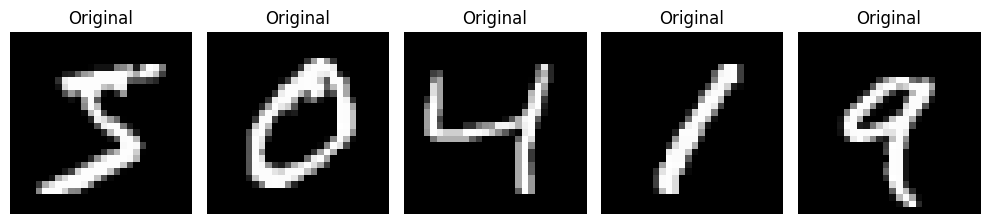

In [186]:
# Visualize some original and augmented images
plt.figure(figsize=(10, 3))
for i, original in enumerate(x_train[:5]):
    # Original image
    plt.subplot(1, 5, i + 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Data Augmentation and Normalization (3pts)
For now, we just implement the these functions.

We will apply data augmentation to the training data during training to increase data diversity.

Also it is common to apply normalization after augmentation since many augmentation methods especially color-related ones need to be done at the RGB color space.

### Augmentation (2pts)

In [187]:
# Horizontally flip each image at the given probability
def augment_images(images, prob=0.5):
    augmented_images = []
    for image in images:
        # Note: don't change the `image` in-place
        # ========== YOUR CODE STARTS HERE ==========
        if random.random() < prob:
            augmented_images.append(np.fliplr(image))
        else:
            augmented_images.append(image.copy())
        # ========== YOUR CODE ENDS HERE ============

    return np.array(augmented_images)

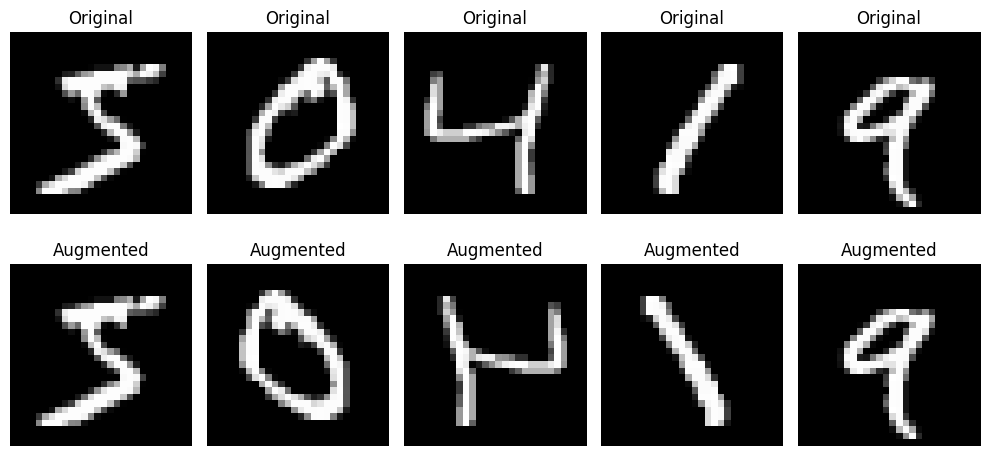

In [188]:
# Visualize some original and augmented images
plt.figure(figsize=(10, 5))
for i, (original, augmented) in enumerate(zip(x_train[:5], augment_images(x_train)[:5])):
    # Original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Augmented image
    plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(augmented, cmap='gray')
    plt.title("Augmented")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Normalization (1pt)
Apply range normalization to scale all pixel values to the range [-0.5, 0.5].

In [189]:
def normalize_images(images):
    # ========== YOUR CODE STARTS HERE ==========
    return images.astype(np.float32) / 255.0 - 0.5
    # ========== YOUR CODE ENDS HERE ============

In [190]:
assert normalize_images(x_train).max() <= 0.5
assert normalize_images(x_train).min() >= -0.5

## Model (9pts)

In [191]:
class FullyConnectedNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases for input-to-hidden and hidden-to-output layers. (2pts)
        # ========== YOUR CODE STARTS HERE ==========
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros(output_size)
        # ========== YOUR CODE ENDS HERE ============

        # Store the intermediate results with these variables during each forward.
        # They will be used for back-propagation.
        # z1: output from the first fully-connected layer
        # a1: relu activation with z1
        # z2: output from the second fully-connected layer
        # a2: final output after softmax
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None

    def relu(self, x):
        # ReLU activation function. (1pt)
        # ========== YOUR CODE STARTS HERE ==========
        return np.maximum(0, x)
        # ========== YOUR CODE ENDS HERE ============

    def softmax(self, x):
        # Softmax activation function. (2pt)
        # ========== YOUR CODE STARTS HERE ==========
        exp_x = np.exp(x - np.max(x, axis = 1, keepdims = True))
        return exp_x / np.sum(exp_x, axis = 1, keepdims = True)
        # ========== YOUR CODE ENDS HERE ============

    def forward(self, x):
        # Forward pass through the network. (4pts)
        # ========== YOUR CODE STARTS HERE ==========
        self.z1 = np.dot(x, self.W1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.softmax(self.z2)
        # ========== YOUR CODE ENDS HERE ============

        return self.a2

In [192]:
dummy_model = FullyConnectedNetwork(4, 16, 8)
dummy_model.W1[:] = 2
dummy_model.b1[:] = 3
dummy_model.W2[:] = 4
dummy_model.b2[:] = 5
dummy_input = np.ones((2, 4))

dummy_pred = dummy_model.forward(dummy_input)

In [193]:
assert float(dummy_pred.mean()) == 0.125, dummy_pred
print("Dummy pred:", dummy_pred)

Dummy pred: [[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
 [0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]]


## Optimization Targets (11pts)

### Cross-Entrophy Loss (2pt)

In [194]:
def cross_entropy_loss(y_pred, y_true):
    # Compute the cross-entropy loss. (2pts)
    # Remember to normalize the loss value with the current batch size
    # so that the batch size won't affect the loss's magnitude.
    # ========== YOUR CODE STARTS HERE ==========
    m = y_pred.shape[0]
    correct_logprobs = -np.log(y_pred[np.arange(m), y_true] + 1e-8)
    loss = np.sum(correct_logprobs) / m
    return loss
    # ========== YOUR CODE ENDS HERE ============

In [195]:
dummy_pred = np.arange(20).reshape(5, 4).astype("float")
dummy_pred /= dummy_pred.sum(1, keepdims=True)

dummy_true = np.ones(5).astype("int")
dummy_loss = cross_entropy_loss(dummy_pred, dummy_true)
assert round(float(dummy_loss), 1) == 1.5, dummy_loss
print("Dummy loss:", dummy_loss)

Dummy loss: 1.5106083901402336


### Back-Propagation for Cross-Entrophy Loss (5pts)

In [196]:
def cross_entropy_backward(y_pred, y_true, x, model):
    # Compute gradients for the cross-entropy loss with respect to the model parameters. (10pts)
    # ========== YOUR CODE STARTS HERE ==========
    m = x.shape[0]
    grad_z2 = y_pred.copy()
    grad_z2[np.arange(m), y_true] -= 1
    grad_z2 /= m
    
    dW2 = np.dot(model.a1.T, grad_z2)
    db2 = np.sum(grad_z2, axis = 0)
    grad_a1 = np.dot(grad_z2, model.W2.T)
    grad_z1 = grad_a1 * (model.z1 > 0)
    dW1 = np.dot(x.T, grad_z1)
    db1 = np.sum(grad_z1, axis = 0)
    # ========== YOUR CODE ENDS HERE ============
    return dW1, db1, dW2, db2

In [197]:
dummy_model = FullyConnectedNetwork(4, 16, 8)
dummy_model.W1[:] = 2
dummy_model.b1[:] = 3
dummy_model.W2[:] = 4
dummy_model.b2[:] = 5
dummy_input = np.ones((2, 4))

dummy_pred = dummy_model.forward(dummy_input)
dummy_true = np.ones(2).astype("int")
dummy_grads = cross_entropy_backward(dummy_pred, dummy_true, dummy_input, dummy_model)

In [198]:
dummy_grads[3].mean()

np.float64(0.0)

In [199]:
assert dummy_grads[0].shape == dummy_model.W1.shape, (dummy_grads[0].shape, dummy_model.W1.shape)
assert dummy_grads[1].shape == dummy_model.b1.shape, (dummy_grads[1].shape, dummy_model.b1.shape)
assert dummy_grads[2].shape == dummy_model.W2.shape, (dummy_grads[2].shape, dummy_model.W2.shape)
assert dummy_grads[3].shape == dummy_model.b2.shape, (dummy_grads[3].shape, dummy_model.b2.shape)
print("Dummy gradients:", dummy_grads)

Dummy gradients: (array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([[ 1.375, -9.625,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375],
       [ 1.375, -9.625,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375],
       [ 1.375, -9.625,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375],
       [ 1.375, -9.625,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375],
       [ 1.375, -9.625,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375],
       [ 1.375, -9.625,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375],
       [ 1.375, -9.625,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375],
       [ 1.375, -9.625,  1.375,  1.375,  1.375,  1.375,  1.375,  1.375],
       [ 1.375, -9.625,  1.375,

### L2 Regularization (2pts)

In [200]:
def l2_regularization_loss(model, lambda_reg):
    # ========== YOUR CODE STARTS HERE ==========
    return lambda_reg * (np.sum(model.W1**2) + np.sum(model.W2**2))
    # ========== YOUR CODE ENDS HERE ============

In [201]:
dummy_model = FullyConnectedNetwork(4, 16, 8)
dummy_model.W1[:] = 2
dummy_model.b1[:] = 3
dummy_model.W2[:] = 4
dummy_model.b2[:] = 5
dummy_l2 = l2_regularization_loss(dummy_model, 1.0)
assert int(dummy_l2) == 2304, dummy_l2
print("Dummy L2:", dummy_l2)

Dummy L2: 2304.0


### Back-Propagation for L2 Regularization (2pts)

In [202]:
def l2_regularization_backward(model, lambda_reg):
    # ========== YOUR CODE STARTS HERE ==========
    dW1_reg = 2 * lambda_reg * model.W1
    dW2_reg = 2 * lambda_reg * model.W2
    # ========== YOUR CODE ENDS HERE ============
    return dW1_reg, dW2_reg

In [203]:
dummy_model = FullyConnectedNetwork(4, 16, 8)
dummy_model.W1[:] = 2
dummy_model.b1[:] = 3
dummy_model.W2[:] = 4
dummy_model.b2[:] = 5
dummy_l2_grad = l2_regularization_backward(dummy_model, 1.0)

In [204]:
assert dummy_l2_grad[0].shape == dummy_model.W1.shape, (dummy_l2_grad[0].shape, dummy_model.W1.shape)
assert dummy_l2_grad[1].shape == dummy_model.W2.shape, (dummy_l2_grad[1].shape, dummy_model.W2.shape)
print("Dummy gradients:", dummy_l2_grad)

Dummy gradients: (array([[4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]]), array([[8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8.]]))


## SGD Optimizer (1pt)

In [205]:
class SGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
    
    def update(self, params, grads):
        updated_params = []
        for param, grad in zip(params, grads):
            # ========== YOUR CODE STARTS HERE ==========
            updated_params.append(param - self.learning_rate * grad)
            # ========== YOUR CODE ENDS HERE ============
        return updated_params

## Trainer (11pts)

In [206]:
class Trainer:
    def __init__(self, model, optimizer, lambda_reg=0.0):
        self.model = model
        self.optimizer = optimizer
        self.lambda_reg = lambda_reg

    def train(self, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
        losses_train, losses_val = [], []
        accs_val = []

        num_batches = (x_train.shape[0] + batch_size - 1) // batch_size

        for epoch_id in tqdm(range(epochs)):
            epoch_loss = 0
            # Shuffle the training set before each epoch (2pts)
            # ========== YOUR CODE STARTS HERE ==========
            indices = np.arange(x_train.shape[0])
            np.random.shuffle(indices)
            x_train = x_train[indices]
            y_train = y_train[indices]
            # ========== YOUR CODE ENDS HERE ============

            for batch in range(num_batches):
                # Get the batch data (1pt)
                # ========== YOUR CODE STARTS HERE ==========
                start = batch * batch_size
                end = start + batch_size
                x_batch = x_train[start:end]
                y_batch = y_train[start:end]
                # ========== YOUR CODE ENDS HERE ============

                # Apply augmentation and normalization (1pt)
                # ========== YOUR CODE STARTS HERE ==========
                x_batch = augment_images(x_batch)
                x_batch = normalize_images(x_batch)
                # ========== YOUR CODE ENDS HERE ============

                x_batch = x_batch.reshape(x_batch.shape[0], -1)
                y_pred = self.model.forward(x_batch)
                loss = cross_entropy_loss(y_pred, y_batch)

                if self.lambda_reg > 0:
                    # Add l2 regularization to the loss (1pt)
                    # ========== YOUR CODE STARTS HERE ==========
                    loss += l2_regularization_loss(self.model, self.lambda_reg)
                    # ========== YOUR CODE ENDS HERE ============

                # Compute gradient from Cross-Entrophy Loss (1pt)
                # ========== YOUR CODE STARTS HERE ==========
                dW1, db1, dW2, db2 = cross_entropy_backward(y_pred, y_batch, x_batch, self.model)
                # ========== YOUR CODE ENDS HERE ============

                if self.lambda_reg > 0:
                    # Add L2 gradients if regularization is applied (1pt)
                    # ========== YOUR CODE STARTS HERE ==========
                    dW1_reg, dW2_reg = l2_regularization_backward(self.model, self.lambda_reg)
                    dW1 += dW1_reg
                    dW2 += dW2_reg
                    # ========== YOUR CODE ENDS HERE ============

                # Update parameters using the optimizer (1pt)
                # ========== YOUR CODE STARTS HERE ==========
                updated_params = self.optimizer.update(
                    [self.model.W1, self.model.b1, self.model.W2, self.model.b2],
                    [dW1, db1, dW2, db2]
                )
                self.model.W1, self.model.b1, self.model.W2, self.model.b2 = updated_params
                # ========== YOUR CODE ENDS HERE ============

                epoch_loss += loss

            # Print epoch statistics
            loss_train = epoch_loss / num_batches
            loss_val, acc_val = self.evaluate(x_val, y_val)
            losses_train.append(loss_train)
            losses_val.append(loss_val)
            accs_val.append(acc_val)
            print(f"Epoch {epoch_id + 1}/{epochs}, Training Loss: {loss:.4f}, Validation Loss: {loss_val:.4f}, Validation ACC: {acc_val:.4f}")

        return losses_train, losses_val, accs_val

    def evaluate(self, x, y):
        # Only do normalization when testing on validation or test set (1pt)
        # ========== YOUR CODE STARTS HERE ==========
        x = normalize_images(x)
        # ========== YOUR CODE ENDS HERE ============

        x = x.reshape(x.shape[0], -1)
        y_pred = self.model.forward(x)

        # Compute Cross-Entrophy Loss and L2 Regularization if needed (1pt)
        # ========== YOUR CODE STARTS HERE ==========
        loss = cross_entropy_loss(y_pred, y)
        if self.lambda_reg > 0:
            loss += l2_regularization_loss(self.model, self.lambda_reg)
        # ========== YOUR CODE ENDS HERE ============

        # Compute accuracy (1pt)
        # ========== YOUR CODE STARTS HERE ==========
        acc = np.mean(np.argmax(y_pred, axis = 1) == y)
        # ========== YOUR CODE ENDS HERE ============

        return loss, acc

## Training (7pts)

### Model Definition

In [207]:
hidden_size = 128

# define input size and output size (1pt)
# ========== YOUR CODE STARTS HERE ==========
input_size = 28 * 28
output_size = 10
# ========== YOUR CODE ENDS HERE ============

model = FullyConnectedNetwork(input_size, hidden_size, output_size)

### Hyper-Parameters (6pts)

You need to reach an final ACC > 0.9 on the test set to get points for this part.

In [208]:
# ========== YOUR CODE STARTS HERE ==========
lr = 0.1
lambda_reg = 0.001
epochs = 10
batch_size = 64
# ========== YOUR CODE ENDS HERE ============

In [209]:
optimizer = SGD(learning_rate=lr)
trainer = Trainer(model, optimizer, lambda_reg=lambda_reg)

In [210]:
losses_train, losses_val, accs_val = trainer.train(x_train, y_train, x_val=x_val, y_val=y_val, epochs=epochs, batch_size=batch_size)

 10%|█████████▍                                                                                    | 1/10 [00:00<00:05,  1.53it/s]

Epoch 1/10, Training Loss: 0.9610, Validation Loss: 0.7497, Validation ACC: 0.7665


 20%|██████████████████▊                                                                           | 2/10 [00:01<00:05,  1.54it/s]

Epoch 2/10, Training Loss: 0.4305, Validation Loss: 0.5803, Validation ACC: 0.8428


 30%|████████████████████████████▏                                                                 | 3/10 [00:01<00:04,  1.56it/s]

Epoch 3/10, Training Loss: 0.3281, Validation Loss: 0.4376, Validation ACC: 0.8929


 40%|█████████████████████████████████████▌                                                        | 4/10 [00:02<00:03,  1.57it/s]

Epoch 4/10, Training Loss: 0.2414, Validation Loss: 0.3876, Validation ACC: 0.9198


 50%|███████████████████████████████████████████████                                               | 5/10 [00:03<00:03,  1.58it/s]

Epoch 5/10, Training Loss: 0.4860, Validation Loss: 0.4402, Validation ACC: 0.8994


 60%|████████████████████████████████████████████████████████▍                                     | 6/10 [00:03<00:02,  1.58it/s]

Epoch 6/10, Training Loss: 0.4263, Validation Loss: 0.8151, Validation ACC: 0.7949


 70%|█████████████████████████████████████████████████████████████████▊                            | 7/10 [00:04<00:01,  1.59it/s]

Epoch 7/10, Training Loss: 0.3606, Validation Loss: 0.3998, Validation ACC: 0.9152


 80%|███████████████████████████████████████████████████████████████████████████▏                  | 8/10 [00:05<00:01,  1.58it/s]

Epoch 8/10, Training Loss: 0.5986, Validation Loss: 0.4096, Validation ACC: 0.9144


 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 9/10 [00:05<00:00,  1.59it/s]

Epoch 9/10, Training Loss: 0.4426, Validation Loss: 0.4118, Validation ACC: 0.9170


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]

Epoch 10/10, Training Loss: 0.3130, Validation Loss: 0.3805, Validation ACC: 0.9285


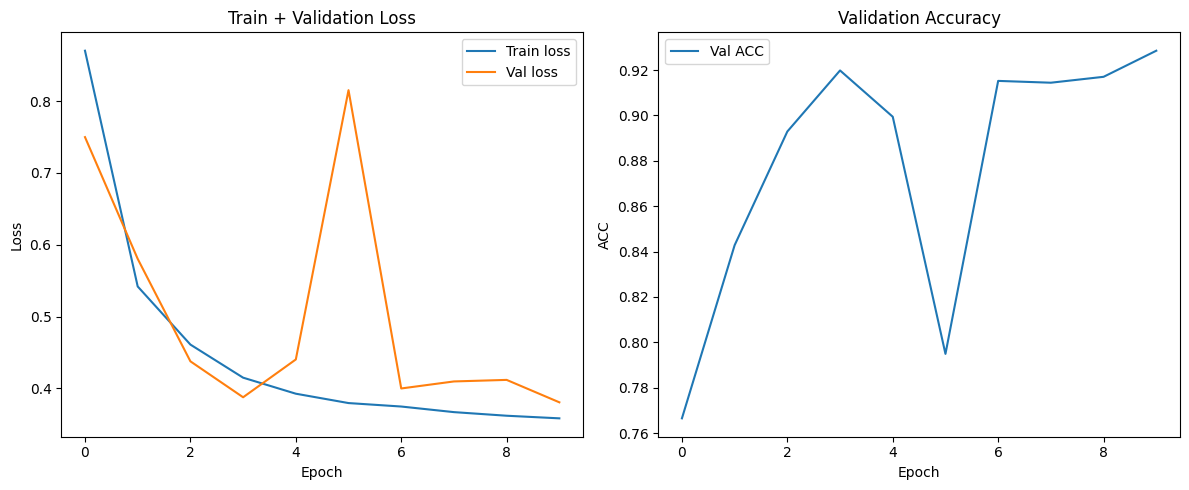

In [211]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

axes[0].plot(np.arange(epochs), losses_train, label="Train loss")
axes[0].plot(np.arange(epochs), losses_val, label="Val loss")
axes[0].set_title("Train + Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(np.arange(epochs), accs_val, label="Val ACC")
axes[1].set_title("Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("ACC")
axes[1].legend()

plt.tight_layout()
plt.show()

### Evaluation on Test Set

In [212]:
loss_test, loss_acc = trainer.evaluate(x_test, y_test)
print(f"Test Loss: {loss_test}")
print(f"Test ACC: {loss_acc}")

Test Loss: 0.3772692411332635
Test ACC: 0.9274


## Training with SGD + Momentum (9pts)

### SGD + Momentum (4pt)

In [213]:
class SGDMomentum:
    def __init__(self, learning_rate, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.velocity = {}

    def update(self, params, grads):
        updated_params = []
        for i, (param, grad) in enumerate(zip(params, grads)):
            # ========== YOUR CODE STARTS HERE ==========
            if i not in self.velocity:
                self.velocity[i] = np.zeros_like(grad)
            self.velocity[i] = self.momentum * self.velocity[i] - self.learning_rate * grad
            updated_params.append(param + self.velocity[i])
            # ========== YOUR CODE ENDS HERE ============

        return updated_params

### Hyper-Parameters (5pts)

You need to reach an final ACC > 0.9 on the test set to get points for this part.

In [214]:
# ========== YOUR CODE STARTS HERE ==========
lr = 0.05
lambda_reg = 0.0001
epochs = 30
batch_size = 64
# ========== YOUR CODE ENDS HERE ============

In [215]:
model = FullyConnectedNetwork(input_size, hidden_size, output_size)
optimizer = SGDMomentum(learning_rate=lr)
trainer = Trainer(model, optimizer, lambda_reg=lambda_reg)

In [216]:
losses_train, losses_val, accs_val = trainer.train(x_train, y_train, x_val=x_val, y_val=y_val, epochs=epochs, batch_size=batch_size)

  3%|███▏                                                                                          | 1/30 [00:00<00:21,  1.37it/s]

Epoch 1/30, Training Loss: 0.5026, Validation Loss: 0.3892, Validation ACC: 0.8817


  7%|██████▎                                                                                       | 2/30 [00:01<00:20,  1.38it/s]

Epoch 2/30, Training Loss: 0.2633, Validation Loss: 0.2644, Validation ACC: 0.9320


 10%|█████████▍                                                                                    | 3/30 [00:02<00:19,  1.40it/s]

Epoch 3/30, Training Loss: 0.1669, Validation Loss: 0.2391, Validation ACC: 0.9426


 13%|████████████▌                                                                                 | 4/30 [00:02<00:18,  1.40it/s]

Epoch 4/30, Training Loss: 0.1650, Validation Loss: 0.3294, Validation ACC: 0.9171


 17%|███████████████▋                                                                              | 5/30 [00:03<00:17,  1.41it/s]

Epoch 5/30, Training Loss: 0.3535, Validation Loss: 0.2621, Validation ACC: 0.9389


 20%|██████████████████▊                                                                           | 6/30 [00:04<00:17,  1.40it/s]

Epoch 6/30, Training Loss: 0.0644, Validation Loss: 0.2705, Validation ACC: 0.9358


 23%|█████████████████████▉                                                                        | 7/30 [00:05<00:16,  1.40it/s]

Epoch 7/30, Training Loss: 0.1988, Validation Loss: 0.2296, Validation ACC: 0.9512


 27%|█████████████████████████                                                                     | 8/30 [00:05<00:15,  1.39it/s]

Epoch 8/30, Training Loss: 0.2402, Validation Loss: 0.2367, Validation ACC: 0.9481


 30%|████████████████████████████▏                                                                 | 9/30 [00:06<00:14,  1.40it/s]

Epoch 9/30, Training Loss: 0.1657, Validation Loss: 0.2248, Validation ACC: 0.9544


 33%|███████████████████████████████                                                              | 10/30 [00:07<00:14,  1.40it/s]

Epoch 10/30, Training Loss: 0.0757, Validation Loss: 0.2170, Validation ACC: 0.9559


 37%|██████████████████████████████████                                                           | 11/30 [00:07<00:13,  1.40it/s]

Epoch 11/30, Training Loss: 0.1872, Validation Loss: 0.2539, Validation ACC: 0.9453


 40%|█████████████████████████████████████▏                                                       | 12/30 [00:08<00:12,  1.40it/s]

Epoch 12/30, Training Loss: 0.1275, Validation Loss: 0.2588, Validation ACC: 0.9429


 43%|████████████████████████████████████████▎                                                    | 13/30 [00:09<00:12,  1.40it/s]

Epoch 13/30, Training Loss: 0.1959, Validation Loss: 0.2291, Validation ACC: 0.9537


 47%|███████████████████████████████████████████▍                                                 | 14/30 [00:10<00:11,  1.39it/s]

Epoch 14/30, Training Loss: 0.0830, Validation Loss: 0.2222, Validation ACC: 0.9559


 50%|██████████████████████████████████████████████▌                                              | 15/30 [00:10<00:10,  1.39it/s]

Epoch 15/30, Training Loss: 0.1347, Validation Loss: 0.2272, Validation ACC: 0.9537


 53%|█████████████████████████████████████████████████▌                                           | 16/30 [00:11<00:10,  1.39it/s]

Epoch 16/30, Training Loss: 0.1526, Validation Loss: 0.2611, Validation ACC: 0.9431


 57%|████████████████████████████████████████████████████▋                                        | 17/30 [00:12<00:09,  1.39it/s]

Epoch 17/30, Training Loss: 0.1041, Validation Loss: 0.2315, Validation ACC: 0.9536


 60%|███████████████████████████████████████████████████████▊                                     | 18/30 [00:12<00:08,  1.39it/s]

Epoch 18/30, Training Loss: 0.2094, Validation Loss: 0.2684, Validation ACC: 0.9418


 63%|██████████████████████████████████████████████████████████▉                                  | 19/30 [00:13<00:07,  1.39it/s]

Epoch 19/30, Training Loss: 0.0878, Validation Loss: 0.2239, Validation ACC: 0.9584


 67%|██████████████████████████████████████████████████████████████                               | 20/30 [00:14<00:07,  1.39it/s]

Epoch 20/30, Training Loss: 0.0909, Validation Loss: 0.2395, Validation ACC: 0.9529


 70%|█████████████████████████████████████████████████████████████████                            | 21/30 [00:15<00:06,  1.39it/s]

Epoch 21/30, Training Loss: 0.0841, Validation Loss: 0.2242, Validation ACC: 0.9587


 73%|████████████████████████████████████████████████████████████████████▏                        | 22/30 [00:15<00:05,  1.39it/s]

Epoch 22/30, Training Loss: 0.6638, Validation Loss: 0.2320, Validation ACC: 0.9532


 77%|███████████████████████████████████████████████████████████████████████▎                     | 23/30 [00:16<00:05,  1.38it/s]

Epoch 23/30, Training Loss: 0.0926, Validation Loss: 0.2363, Validation ACC: 0.9542


 80%|██████████████████████████████████████████████████████████████████████████▍                  | 24/30 [00:17<00:04,  1.38it/s]

Epoch 24/30, Training Loss: 0.3203, Validation Loss: 0.2268, Validation ACC: 0.9561


 83%|█████████████████████████████████████████████████████████████████████████████▌               | 25/30 [00:17<00:03,  1.38it/s]

Epoch 25/30, Training Loss: 0.2079, Validation Loss: 0.2412, Validation ACC: 0.9529


 87%|████████████████████████████████████████████████████████████████████████████████▌            | 26/30 [00:18<00:02,  1.37it/s]

Epoch 26/30, Training Loss: 0.3455, Validation Loss: 0.2467, Validation ACC: 0.9479


 90%|███████████████████████████████████████████████████████████████████████████████████▋         | 27/30 [00:19<00:02,  1.22it/s]

Epoch 27/30, Training Loss: 0.1400, Validation Loss: 0.2153, Validation ACC: 0.9602


 93%|██████████████████████████████████████████████████████████████████████████████████████▊      | 28/30 [00:20<00:01,  1.26it/s]

Epoch 28/30, Training Loss: 0.1561, Validation Loss: 0.2096, Validation ACC: 0.9627


 97%|█████████████████████████████████████████████████████████████████████████████████████████▉   | 29/30 [00:21<00:00,  1.28it/s]

Epoch 29/30, Training Loss: 0.1950, Validation Loss: 0.2137, Validation ACC: 0.9606


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:21<00:00,  1.37it/s]

Epoch 30/30, Training Loss: 0.0861, Validation Loss: 0.2089, Validation ACC: 0.9604


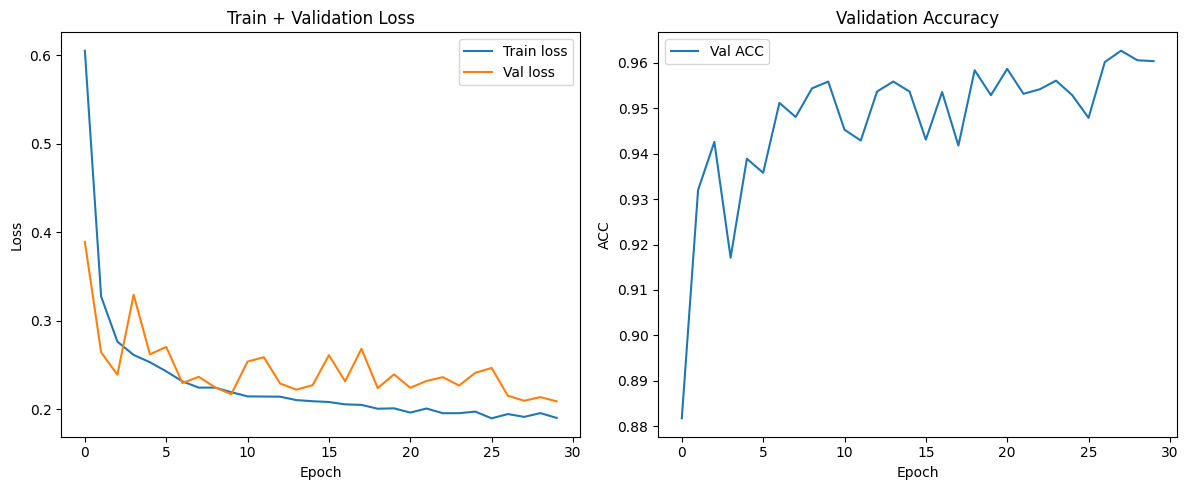

In [217]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

axes[0].plot(np.arange(epochs), losses_train, label="Train loss")
axes[0].plot(np.arange(epochs), losses_val, label="Val loss")
axes[0].set_title("Train + Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(np.arange(epochs), accs_val, label="Val ACC")
axes[1].set_title("Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("ACC")
axes[1].legend()

plt.tight_layout()
plt.show()

### Evaluation on Test Set

In [218]:
loss_test, loss_acc = trainer.evaluate(x_test, y_test)
print(f"Test Loss: {loss_test}")
print(f"Test ACC: {loss_acc}")

Test Loss: 0.20924855577488383
Test ACC: 0.958
